# MAP 554 - Lab 8: Introduction to unconstrained Bayesian optimization

This lab is designed to introduce Bayesian Optimization (BO)

This Lab uses the Python library `GPy` as well as previous Labs and extends it to BO

In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.display import HTML, display

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#Gaussian process library
#!pip install GPy
import GPy

# Install PyDoE package for design of experiment
#!pip install pyDOE2
from pyDOE2 import lhs

from scipy.stats import norm
import scipy

We use here the package `GPy`. The documentation for `GPy` is available at [gpy.readthedocs.io](http://gpy.readthedocs.io/en/deploy/).

A lot of packages that derive Gaussian Processes can be found in python, such as [scikit-learn](https://scikit-learn.org/stable/), [openTURNS](http://www.openturns.org/), [GPflow](https://github.com/GPflow/GPflow), [SMT](https://github.com/SMTorg/smt=), [GPyTorch](https://gpytorch.ai/), etc.

## 2. Definition of EGO algorithm

### 2.1 Global Loop

In [2]:
# The EGO algorithm takes as arguments :
# f_obj :the objective function,
# bounds : the bounds on the design variable
# DoE : normalized DoE (on [0,1]x R^d)
# acquisition_function : acquisition function
# k : the GPy kernel used to define the surrogate model of the objective function
# num_iter : the maximal number of iterations
# threshold_EI : the threshold criterion on EI

# The EGO returns :
# List of evaluated points 
# List of new points along the iterations
# List of current best point
def EGO(f_obj,bounds,\
        k,\
        DoE,\
        acquisition_function,
        num_iter = 50,\
        threshold_EI=1e-6):
    
    current_DoE =DoE
    current_obj_non_norm = f_obj(current_DoE*(bounds[:,1]-bounds[:,0])+bounds[:,0])
    
    # normalization of objective function on current DoE
    mean_obj = current_obj_non_norm.mean()
    std_obj = current_obj_non_norm.std()
    
    #Calculation of initial minimum
    current_obj = (current_obj_non_norm-mean_obj)/std_obj
    current_min = np.min(current_obj)

    ### Print of results
    print("iteration|         current |         best |     value infill")
    print("--------------------------------------------------------")
    iter_ = 0
    EI = 50
    best = []
    while iter_ < num_iter and EI > threshold_EI:#for i in range():
    
        #definition of GP model
        m_obj = GPy.models.GPRegression(current_DoE,current_obj,k)
        #training of GP model)
        m_obj.likelihood.variance = 1e-10
        m_obj.likelihood.variance.fix()
        m_obj.optimize()
        
        #optimization of infill criterion
        x_new,EI = optim_infill(m_obj,current_min,acquisition_function, seed = 0)
            
        #calculation of new point
        y_new = f_obj(np.array([x_new])*(bounds[:,1]-bounds[:,0])+bounds[:,0])
        
        # update of current DoE
        current_DoE = np.append(current_DoE,np.array([x_new]),axis = 0)
        current_obj = np.append(current_obj,(y_new-mean_obj)/std_obj,axis = 0)
        
        # calculation of current minimum
        current_min = np.min(current_obj)
        print("%9.d|%17.4e|%13.04f|%13.04f" %(iter_, y_new, std_obj*current_min+mean_obj,EI))    
        iter_ +=1
        best.append(std_obj*current_min+mean_obj)
        
    return current_DoE*(bounds[:,1]-bounds[:,0])+bounds[:,0],std_obj*current_obj+mean_obj,best,m_obj,mean_obj,std_obj

Efficient Global Optimization (EGO) algorithm needs to define the acquisition function and the way to optimize it, this is defined throught the following functions

### 2.2 Acquisition function

In [3]:
#Definition of acquisition function
# This function takes as arguments the current point to evaluate EI, the surrogate model and the current minimum
# This functions returns  - EI

def EI(x,gp,y_min):
    pred,var = gp.predict(np.array([x]))
    std = np.sqrt(var)

    EI = (y_min-pred)* norm.cdf((y_min-pred)/std)+std*norm.pdf((y_min-pred)/std)
    if np.isnan(EI):
        EI= np.array([[0]])
    return -EI[0][0]


### 2.3 Optimization process to optimize infill criterion


In [4]:
# This function is used to optimize the infill criterion, it takes as arguments :
# m_obj : the GP of the objective function
# y_min : the current minimum
# seed : the seed of the stochastic optimization algorithm

# It returns the location of the best point to infill as well as the optimized value of EI

# Here, the Differential Evolution (See Lecture 1) is used as the EI present a lot of local minima

def optim_infill(m_obj,y_min,acquisition_function,seed):
    f = lambda x : acquisition_function(x,m_obj,y_min)
    bounds_norm = np.zeros((2,len(bounds)))
    if len(bounds)>1:
        bounds_norm[:,0] = 0.
        bounds_norm[:,1] = 1.
    else:
        bounds_norm = [[0.,1.]]

    struct_res = scipy.optimize.differential_evolution(f,\
                                                    popsize=50,
                                                    maxiter =5000,
                                                    bounds = bounds_norm)
    x_opt = struct_res.x
    res = struct_res.fun
    return x_opt,np.abs(res)

## 3. Example on 1 - D function

Here we test the EGO algorithm on the Forrester function defined  on $[0,1]$ as follows : 
 $$ f(z) = (6z-2)^2 \sin(12z-4)$$

In [5]:
# definition of Forrester function
def forrester(z):    
    return (6*z-2)**2*np.sin(12*z-4)

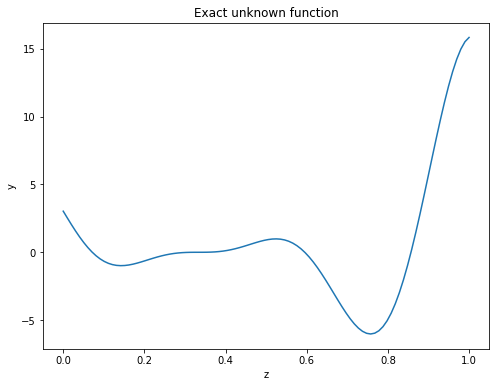

In [6]:
#Visualization of Forrester function : 
# Our sample space: 100 samples in the interval [0,1]
z0 = np.linspace(0.,1.,100)[:, None]
y = forrester(z0)
plt.figure(figsize=(8,6))
plt.plot(z0,y)
plt.xlabel("z")
plt.ylabel("y")
plt.title("Exact unknown function")
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

This function presents 2 minima: one local and one global.
    
Here, we will use an EGO algorithm to find the global optimum

In [7]:
# Definition of an initial DoE

# To generate initial DoE, we use the function 'LHS' of the package pyDOE
# The first argument is the dimension of the design vector, the second is the number of points in the DoE
z_init = lhs(1,4)
bounds = np.array([[0.,1.]])

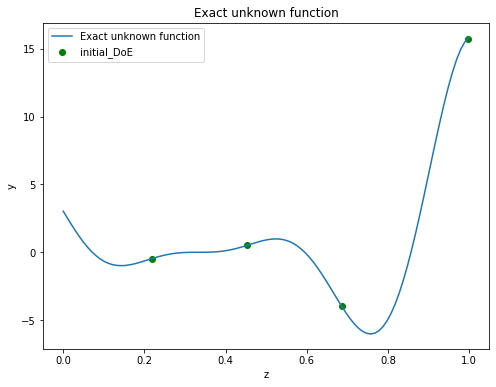

In [8]:
# Visualization of results
plt.figure(figsize=(8,6))
plt.plot(z0,y,label="Exact unknown function")
plt.scatter(z_init,forrester(z_init),c='g',label='initial_DoE')
plt.xlabel("z")
plt.ylabel("y")
plt.title("Exact unknown function")
plt.legend()
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

In [9]:
# Definition of kernel using GPy
k = GPy.kern.RBF(1,ARD = True) # the definition of a RBF kernel for GP is similar to Scikit-learn library

In [10]:
#Run of EGO
EGO_x, EGO_y,best,m_obj,mean_obj,std_obj = EGO(forrester,bounds,\
        k,\
        z_init,\
        EI,\
        num_iter = 50,\
        threshold_EI=1e-6)

iteration|         current |         best |     value infill
--------------------------------------------------------
        0|      -2.8422e-01|      -3.9660|       0.1659
        1|      -5.9939e+00|      -5.9939|       0.1150
        2|       3.0272e+00|      -5.9939|       0.0746
        3|      -5.9770e+00|      -5.9939|       0.0048
        4|      -6.0207e+00|      -6.0207|       0.0035
        5|      -8.1386e-01|      -6.0207|       0.0000
        6|      -6.0207e+00|      -6.0207|       0.0000
        7|      -9.1814e-05|      -6.0207|       0.0000


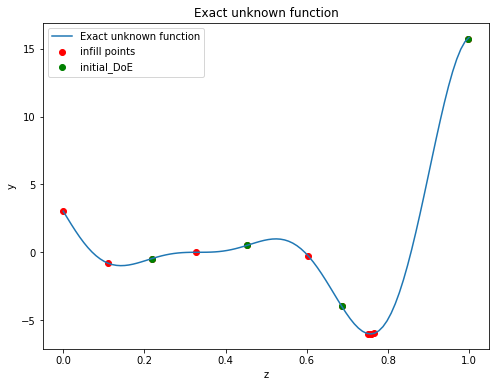

In [11]:
# Visualization of results
plt.figure(figsize=(8,6))
plt.plot(z0,y,label="Exact unknown function")
plt.scatter(EGO_x,EGO_y,c='r',label = 'infill points')
plt.scatter(z_init,forrester(z_init),c='g',label='initial_DoE')
plt.xlabel("z")
plt.ylabel("y")
plt.title("Exact unknown function")
plt.legend()
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

In [12]:
# Analysis of the obtained GP 

pred_y,var_y = m_obj.predict(z0)

Y_pred = pred_y*std_obj +mean_obj

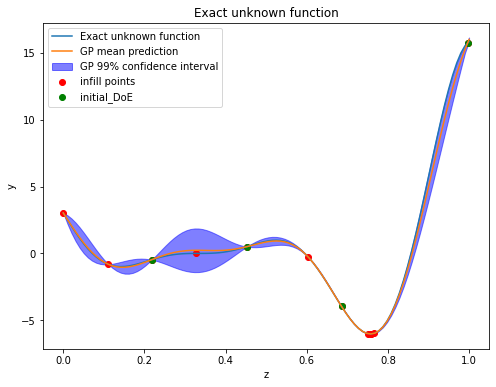

In [13]:
Y_ = Y_pred - 3*(np.sqrt(var_y)*std_obj)
Y_p = Y_pred + 3*(np.sqrt(var_y)*std_obj)

plt.figure(figsize=(8,6))
plt.plot(z0,y,label="Exact unknown function")
plt.plot(z0,Y_pred,label="GP mean prediction")
plt.fill_between(np.reshape(z0,(len(z0),)), np.reshape(Y_,(len(Y_),)), np.reshape(Y_p,(len(Y_p),)),color = 'blue',alpha = 0.5, label = 'GP 99% confidence interval')
plt.scatter(EGO_x,EGO_y,c='r',label = 'infill points')
plt.scatter(z_init,forrester(z_init),c='g',label='initial_DoE')
plt.xlabel("z")
plt.ylabel("y")
plt.title("Exact unknown function")
plt.legend()
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

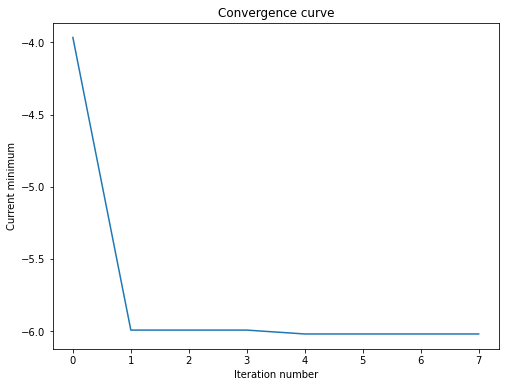

In [14]:
 #convergence curve
plt.figure(figsize=(8,6))
plt.plot(best)
plt.xlabel('Iteration number')
plt.ylabel('Current minimum')
plt.title('Convergence curve')
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page


## 4. Example on 2 - D function

Now we test EGO on multidimensional function. To do so, we consider the Branin function defined as follows :

$$f(\mathbf{z}) = \left(z_2-\frac{5.1z_1^2}{4\pi^2}+\frac{5z_1}{\pi}-6\right)^2+10\left(1.-\frac{1.}{8\pi}\right)\cos(z_1)+10$$

with $z_1 \in [-5,10]$ and $z_2 \in [0 ,15]$

There are 3 global minima  of $0.397887$ located on $(-\pi,12.275)$, $(\pi,2.275)$ and $(9.42478,2.475)$

In [15]:
#Definition of Branin function
def Branin(x):    
    f = np.zeros((len(x),1))
    for i in range(len(x)):
        x1 = x[i][0]
        x2 = x[i][1]
        f[i] = (x2-5.1*x1**2/(4*np.pi**2)+5*x1/np.pi-6)**2+10*(1.-1./(8*np.pi))*np.cos(x1)+10
    return f

bounds = np.array([[-5,10],[0.,15.]])

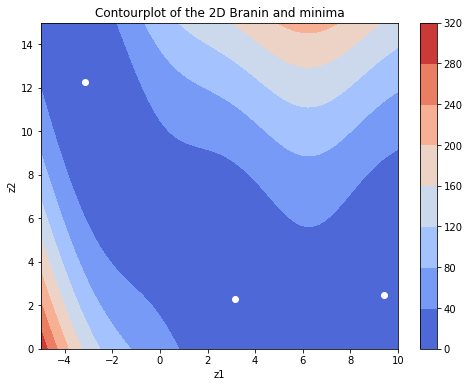

In [16]:
#Visualization of Branin 

#Definition of the initial grid
xx1 = np.linspace(bounds[0][0],bounds[0][1],100)
xx2 = np.linspace(bounds[1][0],bounds[1][1],100)

xx,yy = np.meshgrid(xx1,xx2)

xx_ =xx.reshape((len(xx)**2,1))
yy_ = yy.reshape((len(yy)**2,1))
zz = np.zeros(len(xx_))

#Evaluation of Branin function on the grid
zz = Branin(np.concatenate((xx_,yy_),axis = 1))
zz= zz.reshape(len(xx),len(yy))

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
surf = ax.contourf(xx,yy,zz,cmap = cm.coolwarm)
opt = [[-np.pi,12.275],[np.pi,2.275],[9.42478,2.475]]
for x_opt in opt:
    plt.scatter(x_opt[0],x_opt[1],c='w')
plt.xlabel("z1")
plt.ylabel("z2")
plt.title('Contourplot of the 2D Branin and minima')
plt.colorbar(surf)
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page


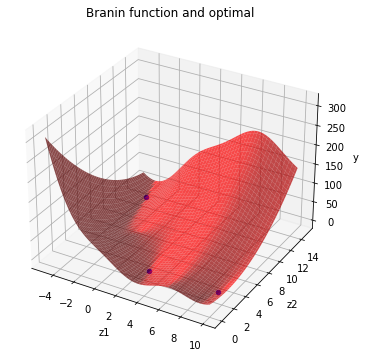

In [17]:
## figure plot
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection = '3d')
plt.title('Branin function and optimal')
surf = ax.plot_surface(xx, yy, zz, color='r', alpha=0.7)
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('y')
for x_opt in opt:
    ax.scatter(x_opt[0],x_opt[1],Branin(np.array([[x_opt[0],x_opt[1]]]))[0][0],c='b', marker='o')
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

In [18]:
#EGO on Branin function
z_init = lhs(2,10)
# Definition of kernel
k = GPy.kern.RBF(2,ARD = True) 

In [19]:
#Run of EGO
EGO_branin_x, EGO_branin_y,best_branin,m_obj,mean_obj,std_obj = EGO(Branin,bounds,\
                    k,\
                    z_init,\
                    EI,
                    num_iter = 30,\
                    threshold_EI=1e-4)

iteration|         current |         best |     value infill
--------------------------------------------------------
        0|       6.4310e+01|       6.1996|       0.2703
        1|       2.1490e+01|       6.1996|       0.4565
        2|       9.7728e+01|       6.1996|       0.1794
        3|       4.3862e+00|       4.3862|       0.5476
        4|       9.7843e+00|       4.3862|       0.3260
        5|       1.9045e+00|       1.9045|       0.1365
        6|       1.0961e+01|       1.9045|       0.1568
        7|       2.4145e+00|       1.9045|       0.0763
        8|       2.4836e+00|       1.9045|       0.0391
        9|       4.1762e-01|       0.4176|       0.0349
       10|       5.2110e-01|       0.4176|       0.0073
       11|       4.4523e-01|       0.4176|       0.0051
       12|       4.4432e-01|       0.4176|       0.0016
       13|       4.0301e-01|       0.4030|       0.0002
       14|       4.1745e-01|       0.4030|       0.0003
       15|       3.9796e-01|       0.3980|

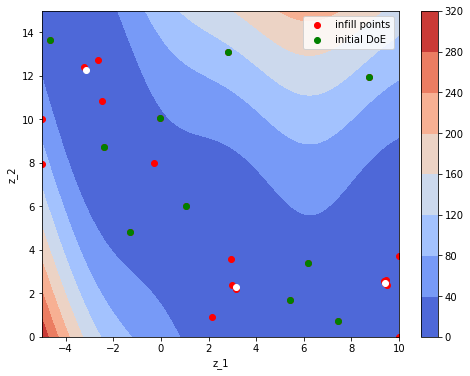

In [20]:
#visualization of result 

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
surf = ax.contourf(xx,yy,zz,cmap = cm.coolwarm)
opt = [[-np.pi,12.275],[np.pi,2.275],[9.42478,2.475]]

plt.scatter(EGO_branin_x[:,0],EGO_branin_x[:,1],c='r',label='infill points')
plt.scatter(z_init[:,0]*(bounds[0,1]-bounds[0,0])+bounds[0,0],\
            z_init[:,1]*(bounds[1,1]-bounds[1,0])+bounds[1,0],c='g',label='initial DoE')
for x_opt in opt:
    plt.scatter(x_opt[0],x_opt[1],c='w')
plt.legend()
plt.xlabel("z_1")
plt.ylabel("z_2")
plt.colorbar(surf)
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

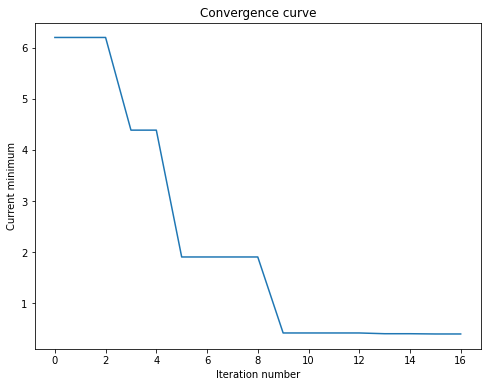

In [21]:
#convergence curve
plt.figure(figsize=(8,6))
plt.plot(best_branin)
plt.xlabel('Iteration number')
plt.ylabel('Current minimum')
plt.title('Convergence curve')
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

# Exercice 1

Implement another criterion : Probability of Improvement and test it on Forrester and Branin functions

iteration|         current |         best |     value infill
--------------------------------------------------------
        0|       6.2385e+00|       6.2385|       1.0000
        1|       4.9666e+00|       4.9666|       1.0000
        2|       4.5037e+00|       4.5037|       1.0000
        3|       4.1802e+00|       4.1802|       1.0000
        4|       3.8152e+00|       3.8152|       1.0000
        5|       3.7762e+00|       3.7762|       1.0000
        6|       3.7643e+00|       3.7643|       0.9430
        7|       3.7140e+00|       3.7140|       0.7789
        8|       3.1615e+00|       3.1615|       1.0000
        9|       2.9452e+00|       2.9452|       1.0000
       10|       2.5755e+00|       2.5755|       1.0000
       11|       2.1541e+00|       2.1541|       0.7559
       12|       2.1607e+00|       2.1541|       0.5436
       13|       3.2463e+00|       2.1541|       0.3856
       14|       1.5546e+00|       1.5546|       1.0000
       15|       7.9712e-01|       0.7971|

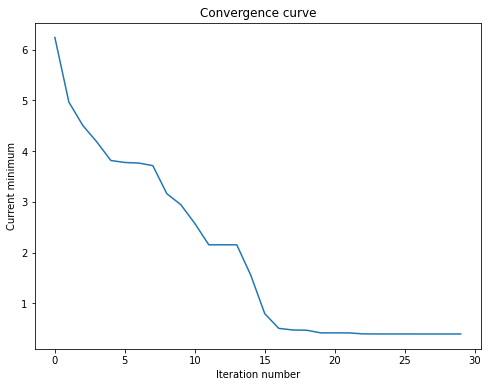

In [23]:

def PI(x,gp,y_min):
    pred,var = gp.predict(np.array([x]))
    std = np.sqrt(var)
    
    PI = norm.cdf((y_min-pred)/std)
    if np.isnan(PI):
        PI= np.array([[0]])
    return -PI[0][0]

#EGO on Branin function
z_init = lhs(2,10)
# Definition of kernel
k = GPy.kern.RBF(2,ARD = True) 

#Run of EGO
EGO_branin_x, EGO_branin_y,best_branin,m_obj,mean_obj,std_obj = EGO(Branin,bounds,\
                    k,\
                    z_init,\
                    PI,
                    num_iter = 30,\
                    threshold_EI=1e-4)

#convergence curve
plt.figure(figsize=(8,6))
plt.plot(best_branin)
plt.xlabel('Iteration number')
plt.ylabel('Current minimum')
plt.title('Convergence curve')
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

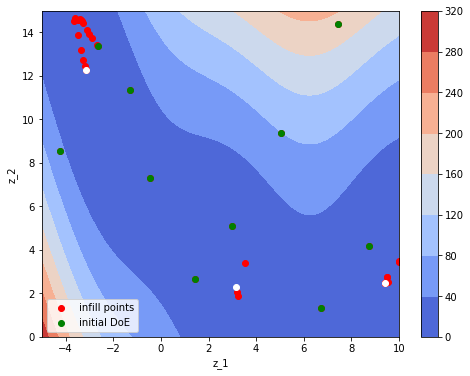

In [24]:
#visualization of result 

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
surf = ax.contourf(xx,yy,zz,cmap = cm.coolwarm)
opt = [[-np.pi,12.275],[np.pi,2.275],[9.42478,2.475]]

plt.scatter(EGO_branin_x[:,0],EGO_branin_x[:,1],c='r',label='infill points')
plt.scatter(z_init[:,0]*(bounds[0,1]-bounds[0,0])+bounds[0,0],\
            z_init[:,1]*(bounds[1,1]-bounds[1,0])+bounds[1,0],c='g',label='initial DoE')
for x_opt in opt:
    plt.scatter(x_opt[0],x_opt[1],c='w')
plt.legend()
plt.xlabel("z_1")
plt.ylabel("z_2")
plt.colorbar(surf)
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

# Exercice 2

Consider the Six Hump Camel function and test EGO with EI and PI.

Six Hump Camel function is defined as follows : 

$$f(\mathbf{z}) = \left(4-2.1z_1^2+\frac{z_1^4}{3}\right)z_1^2+ z_1z_2+(4z_2^2-4)z_2^2$$

with $z_1 \in [-2,2]$ and $z_2 \in [-1 ,1]$

Perform the optimization of the function using Bayesian Optimization

Clue : there are two global optima of $-1.0316$

In [29]:
def f(z):
    z1 = z[0]
    z2 = z[1]
    z12 = z1*z1
    z22 = z2*z2
    return (4-2.1*z12+z12*z12/3)*z12+z1*z2+(4*z22-4)*z22

In [30]:
#EGO on 
z_init = lhs(2,10)
# Definition of kernel
k = GPy.kern.RBF(2,ARD = True) 

#Run of EGO
EGO_branin_x, EGO_branin_y,best_branin,m_obj,mean_obj,std_obj = EGO(f,bounds,\
                    k,\
                    z_init,\
                    PI,
                    num_iter = 30,\
                    threshold_EI=1e-4)

#convergence curve
plt.figure(figsize=(8,6))
plt.plot(best_branin)
plt.xlabel('Iteration number')
plt.ylabel('Current minimum')
plt.title('Convergence curve')
display(HTML("""<style>#output-body {display: flex; align-items: center;justify-content: center;}</style>"""))  #to plot at the center of the page

AttributeError: 'list' object has no attribute 'mean'

In [ ]:
c